In [27]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")
%pip install swig
%pip install gymnasium[box2d]

🖥️ Using device: cpu
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Roy_t\OneDrive\Desktop\GitHub\lunar-landar-dqn-recovered\lunar-landar-dqn\lunar_env\Scripts\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Roy_t\OneDrive\Desktop\GitHub\lunar-landar-dqn-recovered\lunar-landar-dqn\lunar_env\Scripts\python.exe -m pip install --upgrade pip' command.


In [28]:
#Import Libraries
import random
from collections import deque
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os
import gymnasium as gym
from tqdm import trange
import imageio
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo

🎒 Step 1: Replay Buffer Code Block

In [29]:
# 🎒 Replay Buffer - Experience Replay Memory
class ReplayBuffer:
    """
    A fixed-size buffer that stores agent experiences for training the Q-network.

    Attributes:
        buffer (deque): A double-ended queue to store experience tuples.
        capacity (int): Maximum number of experiences the buffer can hold.
    """

    def __init__(self, capacity=100_000):
        """
        Initialize the replay buffer.

        Args:
            capacity (int): Maximum number of transitions to store in the buffer.
        """
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        """
        Store a new experience in the buffer.

        Args:
            state (np.ndarray): The current state.
            action (int): The action taken.
            reward (float): The reward received.
            next_state (np.ndarray): The resulting next state.
            done (bool): Whether the episode has ended.
        """
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """
        Sample a batch of experiences from the buffer.

        Args:
            batch_size (int): The number of samples to return.

        Returns:
            tuple of np.ndarrays: Batched (states, actions, rewards, next_states, dones)
        """
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(dones, dtype=np.uint8)
        )

    def __len__(self):
        """
        Return the current size of the buffer.

        Returns:
            int: Number of stored experiences.
        """
        return len(self.buffer)


🧠 Step 2: Q-Network (Neural Net Brain)

In [30]:
# 🧠 Q-Network - The Deep Neural Network Approximator

class QNetwork(nn.Module):
    """
    A feedforward neural network that estimates Q-values for each action
    given a state input from the environment.

    Attributes:
        model (nn.Sequential): The sequential network architecture.
    """

    def __init__(self, state_size, action_size):
        """
        Initialize the Q-network layers.

        Args:
            state_size (int): Dimension of the input state.
            action_size (int): Number of possible discrete actions.
        """
        super(QNetwork, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        )

    def forward(self, x):
        """
        Forward pass of the network.

        Args:
            x (torch.Tensor): The input state tensor.

        Returns:
            torch.Tensor: The predicted Q-values for each action.
        """
        return self.model(x)


🤖 Step 3: DQN Agent Class

In [31]:
# 🤖 DQN Agent - The Reinforcement Learning Engine

class DQNAgent:
    """
    Deep Q-Learning Agent that interacts with and learns from the environment.

    Attributes:
        q_network (QNetwork): Main Q-network used to predict Q-values.
        target_network (QNetwork): Target Q-network for stable learning.
        optimizer (torch.optim.Adam): Optimizer for updating q_network weights.
        buffer (ReplayBuffer): Memory buffer for storing experiences.
        gamma (float): Discount factor for future rewards.
        epsilon (float): Exploration rate for epsilon-greedy policy.
    """

    def __init__(self, state_size, action_size, buffer, lr=1e-3, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        """
        Initialize the agent.

        Args:
            state_size (int): Number of features in the environment state.
            action_size (int): Number of discrete actions.
            buffer (ReplayBuffer): Replay buffer instance.
            lr (float): Learning rate for the optimizer.
            gamma (float): Discount factor.
            epsilon (float): Initial exploration rate.
            epsilon_decay (float): Rate at which epsilon decays.
            epsilon_min (float): Minimum value of epsilon.
        """
        self.q_network = QNetwork(state_size, action_size).to(device)
        self.target_network = QNetwork(state_size, action_size).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.buffer = buffer

        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.action_size = action_size

    def act(self, state):
        """
        Select an action using epsilon-greedy strategy.

        Args:
            state (np.ndarray): Current state.

        Returns:
            int: Action index.
        """
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.q_network(state)
        return q_values.argmax().item()

    def learn(self, batch_size):
        """
        Sample a batch from memory and perform a learning step.

        Args:
            batch_size (int): Size of the mini-batch for learning.
        """
        if len(self.buffer) < batch_size:
            return

        states, actions, rewards, next_states, dones = self.buffer.sample(batch_size)

        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        q_values = self.q_network(states).gather(1, actions)
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1, keepdim=True)[0]
            target_q = rewards + (1 - dones) * self.gamma * next_q_values

        loss = nn.MSELoss()(q_values, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def update_epsilon(self):
        """
        Decay the exploration rate after each episode.
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def update_target_network(self):
        """
        Copy weights from the main Q-network to the target network.
        """
        self.target_network.load_state_dict(self.q_network.state_dict())


🔁 Step 4: Training Loop

In [32]:
# 🔁 Training Loop - Interact, Learn, and Track Progress
import time
from datetime import datetime
import pickle

# Environment setup
env = gym.make("LunarLander-v3")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Agent setup
buffer = ReplayBuffer(capacity=100_000)
agent = DQNAgent(state_size, action_size, buffer)

# Training hyperparameters
num_episodes = 100
batch_size = 64
target_update_freq = 10  # how often to sync target network

# Tracking
reward_history = []
loss_history = []

start_time = time.time()

# Training loop
for episode in trange(num_episodes, desc="🚀 Training"):
    state, _ = env.reset()
    total_reward = 0
    losses = []

    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        agent.buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        # Learning step
        loss = agent.learn(batch_size)
        if loss is not None:
            losses.append(loss)

    # End-of-episode updates
    agent.update_epsilon()
    if episode % target_update_freq == 0:
        agent.update_target_network()

    # Track performance
    reward_history.append(total_reward)
    avg_loss = np.mean(losses) if losses else 0
    loss_history.append(avg_loss)

    # Print episode summary every 20
    if (episode + 1) % 20 == 0:
        print(f"🎯 Episode {episode+1} - Reward: {total_reward:.2f} | Epsilon: {agent.epsilon:.3f} | Loss: {avg_loss:.4f}")

# Save model
model_path = "results/models/dqn_agent.pth"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
torch.save(agent.q_network.state_dict(), model_path)
print(f"✅ Model saved to {model_path}")

# Save reward/loss history
os.makedirs("results/plots", exist_ok=True)
with open("results/plots/reward_history.pkl", "wb") as f:
    pickle.dump(reward_history, f)
with open("results/plots/loss_history.pkl", "wb") as f:
    pickle.dump(loss_history, f)
print("📦 Training history saved to results/plots/")

# Time tracking
elapsed = time.time() - start_time
print(f"🕒 Training completed in {elapsed / 60:.2f} minutes ✅")


🚀 Training:  20%|██        | 20/100 [00:06<00:32,  2.43it/s]

🎯 Episode 20 - Reward: -262.59 | Epsilon: 0.905 | Loss: 60.2719


🚀 Training:  40%|████      | 40/100 [00:17<01:01,  1.02s/it]

🎯 Episode 40 - Reward: -358.63 | Epsilon: 0.818 | Loss: 52.6004


🚀 Training:  60%|██████    | 60/100 [00:24<00:12,  3.21it/s]

🎯 Episode 60 - Reward: -133.78 | Epsilon: 0.740 | Loss: 36.2559


🚀 Training:  80%|████████  | 80/100 [00:33<00:09,  2.16it/s]

🎯 Episode 80 - Reward: -96.35 | Epsilon: 0.670 | Loss: 29.0831


🚀 Training: 100%|██████████| 100/100 [00:41<00:00,  2.40it/s]

🎯 Episode 100 - Reward: -213.43 | Epsilon: 0.606 | Loss: 23.2643
✅ Model saved to results/models/dqn_agent.pth
📦 Training history saved to results/plots/
🕒 Training completed in 0.70 minutes ✅


💾 Save the Trained Model (Run This Once Training is Done)


In [33]:
# 💾 Save Q-network if already trained

model_path = "results/models/dqn_agent.pth"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
torch.save(agent.q_network.state_dict(), model_path)
print(f"✅ Model saved to {model_path}")

✅ Model saved to results/models/dqn_agent.pth


📈 Step 5: Plot Rewards and Training Loss

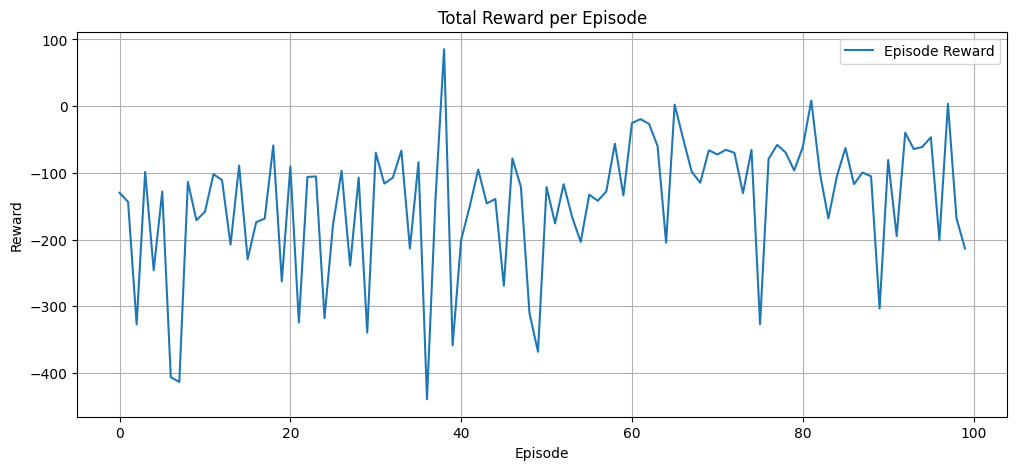

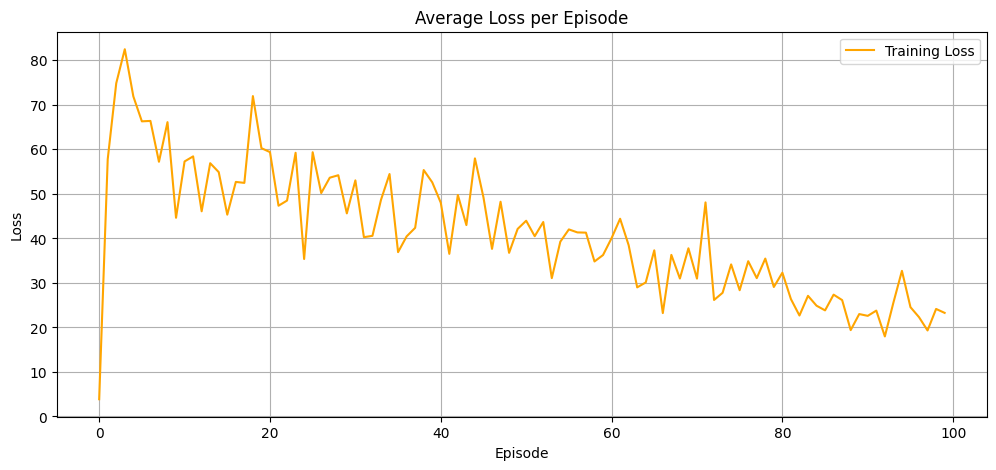

In [34]:
# 📈 Plotting Reward and Training Loss Over Time

# Create directory if needed
os.makedirs("results/plots", exist_ok=True)

plt.figure(figsize=(12, 5))
plt.plot(reward_history, label="Episode Reward")
plt.title("Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)
plt.savefig("results/plots/reward_curve.png")

plt.figure(figsize=(12, 5))
plt.plot(loss_history, label="Training Loss", color="orange")
plt.title("Average Loss per Episode")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("results/plots/loss_curve.png")



🎥 Step 6: Record a Video of the Trained Agent

In [35]:
# 🎥 Record the Trained Agent Landing

# Define video output folder
video_dir = "results/videos"
os.makedirs(video_dir, exist_ok=True)

# Create a wrapped environment for recording
env = gym.make("LunarLander-v3", render_mode="rgb_array")
env = RecordVideo(
    env,
    video_folder=video_dir,
    episode_trigger=lambda episode_id: True,
    name_prefix="lunar_lander"
)

# Reload best-performing agent (optional if already in memory)
agent.epsilon = 0.0  # Turn off exploration for evaluation

for episode in range(1):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.act(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

    print(f"🎬 Episode {episode + 1} finished with reward: {total_reward:.2f}")

env.close()


c:\Users\Roy_t\OneDrive\Desktop\GitHub\lunar-landar-dqn-recovered\lunar-landar-dqn\lunar_env\lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\Roy_t\OneDrive\Desktop\GitHub\lunar-landar-dqn-recovered\lunar-landar-dqn\results\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


🎬 Episode 1 finished with reward: 179.81


🎞️ Convert .mp4 to .gif

In [36]:
# 🌀 Convert Recorded MP4 to GIF

# Locate your video
video_path = "results/videos/lunar_lander-episode-0.mp4"
gif_path = "results/videos/lunar_lander.gif"

# Read frames and save as GIF
reader = imageio.get_reader(video_path, format="ffmpeg")
fps = reader.get_meta_data()["fps"]

writer = imageio.get_writer(gif_path, format="GIF", fps=fps)

for frame in reader:
    writer.append_data(frame)
writer.close()

print(f"✅ GIF saved at: {gif_path}")


✅ GIF saved at: results/videos/lunar_lander.gif


📦 Load the Trained Model Later

In [37]:
# 🔄 Load a previously trained Q-network

# Define state and action dimensions for the LunarLander-v3 environment
state_size = 8        # LunarLander has 8-dimensional state space
action_size = 4       # 4 discrete actions: do nothing, fire left, main, or right engine

# Create a placeholder replay buffer (not used during evaluation, but required by agent)
buffer = ReplayBuffer()

# Instantiate the DQN agent
agent = DQNAgent(state_size, action_size, buffer)

# Load the trained model weights from disk
model_path = "results/models/dqn_agent.pth"
agent.q_network.load_state_dict(torch.load(model_path))

# Set the network to evaluation mode (disables training-specific behaviors like dropout)
agent.q_network.eval()

# Set epsilon to 0 to disable exploration (greedy policy for evaluation)
agent.epsilon = 0.0

print("✅ Loaded trained model and ready for evaluation.")


✅ Loaded trained model and ready for evaluation.


In [38]:
# 🎯 Evaluate the trained agent

num_eval_episodes = 1
env = gym.make("LunarLander-v3", render_mode="human")

for episode in range(num_eval_episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.act(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

    print(f"✅ Evaluation Episode {episode + 1}: Total Reward = {total_reward:.2f}")

env.close()


✅ Evaluation Episode 1: Total Reward = -94.57
